# Global PCA model training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
import math
from nltk.corpus import stopwords
from gensim.utils import tokenize
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
from gensim.models.doc2vec import Doc2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-03-14 22:15:53.810403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-14 22:15:55.359314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-14 22:15:55.359598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-14 22:15:55.359612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/lyrics.csv')

In [4]:
df.head()

,lyrics,genre,id
0,"['So long', 'My sweet love', 'I miss you', ""Mo...",pop,0
1,"[""It won't be long before I'm leaving here"", ""...",pop,1
2,"['Are we crazy?', 'Living our lives through a ...",pop,2
3,"['When did it go wrong, I will never know', 'I...",pop,3
4,"[""I've waited all this time"", 'Counting minute...",pop,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  36000 non-null  object
 1   genre   36000 non-null  object
 2   id      36000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 843.9+ KB


In [6]:
df['lyrics'] = df['lyrics'].apply(ast.literal_eval)

In [7]:
idxs_eval = pd.read_csv('../data/evaluation/lyrics_eval.csv')['id']

In [8]:
df = df.drop(idxs_eval)
df = df.reset_index()

In [9]:
lyrics = list(df['lyrics'])
genres = list(df['genre'])

verses = [verse for lyr in lyrics for verse in lyr]
genres_by_verse = [genre for lyr, genre in zip(lyrics, genres) for verse in lyr]

lyrics_indexes = [i for i, lyr in enumerate(lyrics) for verse in lyr]
verse_indexes = [i for lyr in lyrics for i, verse in enumerate(lyr)]

df_verse = pd.DataFrame({'verse': verses, 'genre': genres_by_verse, 
                         'lyrics_id': lyrics_indexes, 'verse_id': verse_indexes})

#df_verse = df_verse.groupby('genre').sample(frac=0.05, random_state=42).reset_index()
#df_verse = df_verse.groupby('genre').sample(n=25, random_state=42).reset_index()
df_verse

,verse,genre,lyrics_id,verse_id
0,So long,pop,0,0
1,My sweet love,pop,0,1
2,I miss you,pop,0,2
3,More than you'll ever know,pop,0,3
4,Goodbye my moonlight,pop,0,4
...,...,...,...,...
1828696,"And let the virgin conceive""",rock,35849,19
1828697,All the tales are told,rock,35849,20
1828698,All the orchids gone,rock,35849,21
1828699,Lost in my own world,rock,35849,22


In [10]:
#df_verse.groupby('lyrics_id').apply(lambda x: x.sample(n=2))

In [11]:
opening_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmin()]
final_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmax()]
middle_verse = df_verse.groupby('lyrics_id')['verse_id'].apply(
    lambda x: x.iloc[math.ceil(len(x)/2)-1]).reset_index()
middle_verse = pd.merge(df_verse, middle_verse, on=['lyrics_id', 'verse_id'])
df_verse = pd.concat([opening_verse, final_verse, middle_verse]).reset_index(drop=True)
df_verse

,verse,genre,lyrics_id,verse_id
0,So long,pop,0,0
1,It won't be long before I'm leaving here,pop,1,0
2,Are we crazy?,pop,2,0
3,"When did it go wrong, I will never know",pop,3,0
4,I've waited all this time,pop,4,0
...,...,...,...,...
107545,What if every living soul could be upright and...,rock,35845,10
107546,"But oh, the King and the Queen of Light",rock,35846,10
107547,Cause I'm All Shook Up over Peggy Sue,rock,35847,13
107548,The more those feelings grew.,rock,35848,14


## Features

In [12]:
# Get features from a specific verse based on its index in the lyrics
def get_features_verse(lyrics_features, verse_idx):
    return [lyrics_features[verse_idx] for lyrics_features in lyrics_features.values()]

# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j
features_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) 
                    for index, row in df_verse.iterrows()]

features_by_verse = np.array(features_by_verse)

In [13]:
scaler = StandardScaler()
scl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))

In [14]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_features_by_verse)

PCA(n_components=1, random_state=42)

In [15]:
joblib.dump(pca, '../models/gpca/features_pca.pkl')
joblib.dump(scaler, '../models/gpca/features_scaler.pkl')

['../models/gpca/features_scaler.pkl']

In [16]:
scaler = joblib.load('../models/gpca/features_scaler.pkl')
pca = joblib.load('../models/gpca/features_pca.pkl')

["Everyone's coming over tonight", 'I swept the floor and bought some ice', "And I'm picking out something to wear", "As I try to guess the way she'll do her hair", "I'm blowing up they're showing up fast", 'I realize I wore this shirt last time I saw you', 'Man life moves...', 'A little too hard and a little too fast', "We keep talking 'bout good ol' days", "Like they're gonna come back", "Yeah it's nice to see you again", 'Why do the summers have to end?', 'Let the reminiscing begin', 'Pull out old pictures, man what where we thinking?', 'Like my bleached hair with that old shirt', 'We look so stupid, well, except for her', 'And even though everything has changed', 'Time is only half to blame', "And tonight it's true", 'Man, life moves']


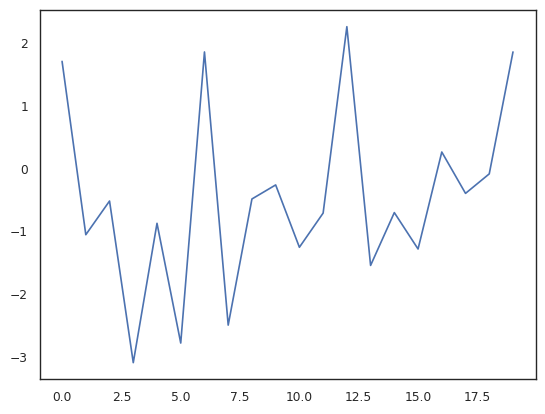

In [17]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = pd.DataFrame(lyrics_statistics(random_lyrics)).values
eg_scl_multi_ts = scaler.transform(eg_multi_ts)
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_scl_multi_ts)))
plt.plot(eg_uni_ts)

## Sentence BERT

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
embeddings = df_verse['verse'].apply(lambda x: model.encode([x]))
embeddings = np.concatenate(embeddings, axis=0)

In [20]:
embeddings.shape

(107550, 384)

In [21]:
pca = PCA(n_components=1, random_state=42)
pca.fit(embeddings)

PCA(n_components=1, random_state=42)

In [22]:
joblib.dump(pca, '../models/gpca/sbert_pca.pkl')

['../models/gpca/sbert_pca.pkl']

In [23]:
pca = joblib.load('../models/gpca/sbert_pca.pkl')

['God is', 'My light in darkness, oh', 'God, God is', 'He, He is my all and all ', 'God is', 'Everything that I felt, praise the Lord', 'Worship Christ with the best of your portions', "I know I won't forget all He's done", "He's the strength in this race that I run", "Every time I look up, I see God's faithfulness", 'And it shows just how much He is miraculous', "I can't keep it to myself, I can't sit here and be still", "Everybody, I will tell 'til the whole world is healed", 'King of Kings, Lord of Lords, all the things He has in store', 'From the rich to the poor, all are welcome through the door', "You won't ever be the same when you call on Jesus' name", "Listen to the words I'm sayin'", "Jesus saved me, now I'm sane", 'And I know, I know God is the force that picked me up', 'I know Christ is the fountain that filled my cup', 'I know God is alive, yeah', 'He has opened up my vision', 'Giving me a revelation', "This ain't 'bout a damn religion", 'Jesus brought a revolution', 'All 

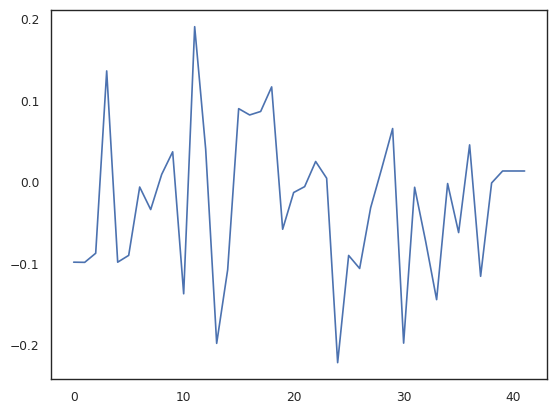

In [24]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = np.array([model.encode(verse) for verse in random_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Doc2Vec

In [25]:
model = Doc2Vec.load("../models/d2v/doc2vec.model")

In [26]:
tokenized_verses = df_verse['verse'].apply(lambda x: list(tokenize(x, lowercase=True)))

In [27]:
embeddings = np.array([model.infer_vector(verse) for verse in tokenized_verses if verse])

In [28]:
scaler = StandardScaler()
scl_embeddings = scaler.fit_transform(embeddings)

In [29]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_embeddings)

PCA(n_components=1, random_state=42)

In [30]:
joblib.dump(pca, '../models/gpca/d2v_pca.pkl')
joblib.dump(scaler, '../models/gpca/d2v_scaler.pkl')

['../models/gpca/d2v_scaler.pkl']

In [31]:
scaler = joblib.load('../models/gpca/d2v_scaler.pkl')
pca = joblib.load('../models/gpca/d2v_pca.pkl')

['Shocklee - Sadler - Ridenhour', "So here we go y'all", 'Little by little you know', 'We got the power', "And the knowledge to move 'em", 'And still rock', 'A super song for the cause so...', 'Feel the load on your brain for the episode', "And we just begun, it's number one y'all", 'Brother Black, the B is back', 'So check it out', "And 'ya don't, I won't, if 'ya still, I will", "Take 3 jams and hold 'em, this what I told 'em", 'To rock the other side, the sucker lied', 'Said he would shock but never tried, and so I', "Took 'em away, I never stayed y'all", 'Called the Flavor Flav to make another record', 'To get played', 'He made a jam to get you stammed', "Back to back in the place where the suckers are basin'", 'Whatever it takes to make it hardcore', 'We gonna roll it raw', "That's what you but it for, c'mon", 'You roll in your ride, the DJ decides', 'To play it on the radio', 'The A side', 'He gives it a try', 'But never gives it a try', 'And the people request the best', 'On the 

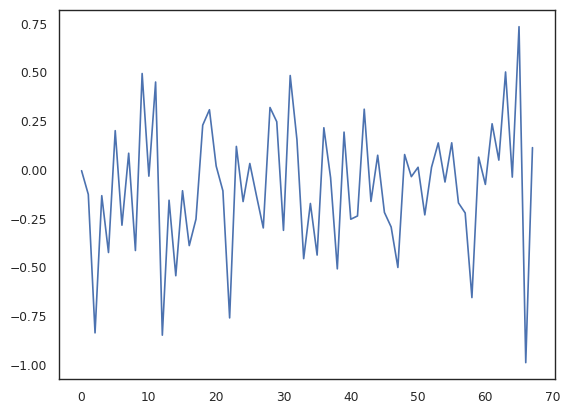

In [32]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

tokenized_lyrics = [list(tokenize(verse, lowercase=True)) for verse in random_lyrics]
    
eg_multi_ts = np.array([model.infer_vector(verse) for verse in tokenized_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Emotion

In [33]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [34]:
def get_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    return logits

In [35]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [36]:
logits_tensor = df_verse['verse'].apply(get_logits, tokenizer=tokenizer, model=model)

In [37]:
# Convert tensors to numpy array
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [38]:
tsne_model = TSNE(n_components=2, random_state=42, init='pca')

In [39]:
tsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])
tsne_logits['label'] = labels

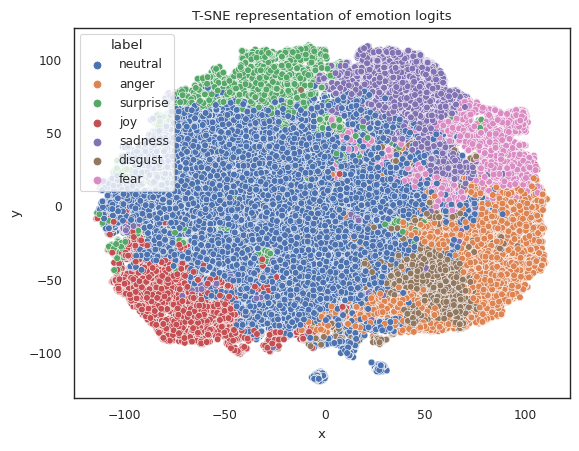

In [40]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=tsne_logits, x='x', y='y', hue='label')
ax.set_title('T-SNE representation of emotion logits')
tikzplotlib.save('../tikz/tsne_emotions.tex')

In [41]:
scaler = StandardScaler()
scl_logits = scaler.fit_transform(logits)

In [42]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_logits)

PCA(n_components=1, random_state=42)

In [43]:
joblib.dump(pca, '../models/gpca/emo_pca.pkl')
joblib.dump(scaler, '../models/gpca/emo_scaler.pkl')

['../models/gpca/emo_scaler.pkl']

In [44]:
scaler = joblib.load('../models/gpca/emo_scaler.pkl')
pca = joblib.load('../models/gpca/emo_pca.pkl')

["There comes a time, in every man's life", "When he gon' have to decide, who he fuckin with", 'Who you fuckin with', "Them niggaz don't care about you", "Them niggaz don't give a fuck about you", 'Why you rappin like that? This street music!', "Yo, let's, talk about it what", "Sheek'll throw the fiend on a nigga guarantee he won't walk up out it", ' With my nickel plated; kinda old', "But the muzzle that I use'll make this motherfucker updated", 'Puh, nigga please; if a nigga had your son', "and had him lookin down the gun you wouldn't need to squeeze", "Uh uh I don't know, don't wanna hear", 'about the money that you had, or what you did a long time ago', "Yo yo the hood is mine; I don't gotta sell a lot", 'I just live off more points than the porcupines', 'Fuh-fuh feel me cousin?', 'Sheek been a problem before this D-Block shit started buzzin', "Some'll say no he wasn't, he turned sick", 'With that women in your family can suck my dick', "And I been red hot e'ry since", "I ain't say

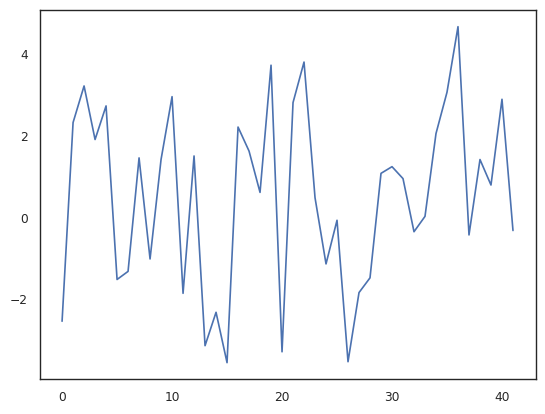

In [45]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in random_lyrics]

# Convert tensors to numpy array
eg_multi_ts = np.array([lt[0].numpy() for lt in logits_tensor])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)